<a href="https://colab.research.google.com/github/Bishara10/EEG-Classification/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [116]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

fatal: destination path 'ML-Classification-model-For-EEG-Recordings' already exists and is not an empty directory.


In [117]:
import os
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import resample, butter, filtfilt
from scipy.stats import pearsonr
import seaborn as sns


%matplotlib notebook
%matplotlib inline


# Preprocess dataset

### Load Data

In [118]:
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
# print(len(file_names_adhd_dataset))
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']
# print(len(file_names_control_dataset))

pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'
outputPath = '/content/preprocessed_dataset/'

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [119]:
# Preprocessed dataset
dataADHD = []
dataControl = []

# parameters for bandpass filter
lowcut = 10.0  # Hz
highcut = 40.0  # Hz

# Set parameters for Spectrogram
original_fs = 128  # Sampling frequency in Hz
target_fs = 64  # Target sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)

In [120]:
# filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    # print(f"Applying bandpass filter: lowcut={lowcut} Hz, highcut={highcut} Hz, fs={fs} Hz")
    # print(f"Normalized frequencies: low={low}, high={high}")
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [121]:
def pearson_correlation_two_signals(signal1, signal2):
  statistic, pvalue = pearsonr(signal1, signal2)

  return statistic, pvalue

In [122]:
# # Function to pad spectrograms to a consistent length
# def pad_spectrogram(sxx, max_length):
#     if sxx.shape[1] < max_length:
#         padding = np.zeros((sxx.shape[0], max_length - sxx.shape[1]))
#         sxx = np.hstack((sxx, padding))
#     else:
#         sxx = sxx[:, :max_length]
#     return sxx

In [123]:
# Function to downsample the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    # print(f"Original signal length: {len(signal)}, Downsampled signal length: {num_samples}")
    return resample(signal, num_samples)

In [124]:
# Preprocessing for an entire recording for a patient
def preprocess_file(input_file, group_category):
  df = pd.read_csv(input_file)
  new_signals = []
  pearson_cors = []

  for column in df.columns:
    signal = df[column].values
    downsampled_signal = downsample_signal(signal, original_fs, target_fs)
    filtered_signal = bandPassFilter(downsampled_signal)
    new_signals.append(filtered_signal)

  for signal in range(len(new_signals) - 1):
    for next_signal in range(len(new_signals)):
      corr, _ = pearson_correlation_two_signals(new_signals[signal], new_signals[next_signal])
      pearson_cors.append(corr)

  if group_category == 'ADHD':
    dataADHD.append(pearson_cors)
  elif group_category == 'CONTROL':
    dataControl.append(pearson_cors)

  # df.to_csv(output_file, index=False)

In [125]:
# Preprocess all recordings for a specific group
def preprocess_group(group_path, group_file_names, output_path, group_category):
  i = 1
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    print(filename + ' data preprocessed ' + str(i) + '/' + str(len(group_file_names)))
    preprocess_file(file_name_and_path, group_category)
    i += 1
  print("=============================== Preprocessing group " + group_category + " successful =============================== ")

In [126]:
# # Calculate the maximum time bins across all files
# def calculate_max_time_bins(files):
#     max_time_bins = 0
#     for file in files:
#         df = pd.read_csv(file)
#         for column in df.columns:
#             signal = df[column].values
#             downsampled_signal = downsample_signal(signal, original_fs, target_fs)
#             f, t, Sxx = spectrogram(downsampled_signal, fs=target_fs, nperseg=nperseg, noverlap=noverlap)
#             max_time_bins = max(max_time_bins, Sxx.shape[1])
#     return max_time_bins


In [127]:
filesADHD = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/' + x for x in file_names_adhd_dataset]
filesControl = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/' + x for x in file_names_control_dataset]

# Find max time bin
# x = calculate_max_time_bins(filesADHD)
# y = calculate_max_time_bins(filesControl)
# maxTimeBins = max(x, y)


# preprocess groups
preprocess_group(pathADHD, file_names_adhd_dataset, outputPath + '/ADHD/', 'ADHD')
preprocess_group(pathControl, file_names_control_dataset, outputPath + '/Control/', 'CONTROL')


v8p.csv data preprocessed 1/61
v35p.csv data preprocessed 2/61
v37p.csv data preprocessed 3/61
v36p.csv data preprocessed 4/61
v38p.csv data preprocessed 5/61
v6p.csv data preprocessed 6/61
v40p.csv data preprocessed 7/61
v39p.csv data preprocessed 8/61
v3p.csv data preprocessed 9/61
v29p.csv data preprocessed 10/61
v30p.csv data preprocessed 11/61
v31p.csv data preprocessed 12/61
v28p.csv data preprocessed 13/61
v279.csv data preprocessed 14/61
v33p.csv data preprocessed 15/61
v25p.csv data preprocessed 16/61
v286.csv data preprocessed 17/61
v250.csv data preprocessed 18/61
v24p.csv data preprocessed 19/61
v246.csv data preprocessed 20/61
v263.csv data preprocessed 21/61
v27p.csv data preprocessed 22/61
v254.csv data preprocessed 23/61
v284.csv data preprocessed 24/61
v238.csv data preprocessed 25/61
v265.csv data preprocessed 26/61
v227.csv data preprocessed 27/61
v215.csv data preprocessed 28/61
v236.csv data preprocessed 29/61
v22p.csv data preprocessed 30/61
v21p.csv data preproce

In [128]:
len(dataADHD)

61

In [129]:
len(dataControl)

60

# Clustering: Kmeans

In [130]:
# Convert the lists into numpy arrays
X_adhd = np.array(dataADHD)
X_control = np.array(dataControl)

# Combine ADHD and control data
X = np.concatenate((X_adhd, X_control))

# Create the label vector (1 for ADHD, 0 for control)
y = np.array([1] * len(X_adhd) + [0] * len(X_control))

In [131]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [132]:


# Initialize the KMeans model with 2 clusters (ADHD and Control)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)

# Fit the model to the data
kmeans.fit(X_scaled)

# Predict cluster labels for the data
cluster_labels = kmeans.predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f"Silhouette Score for K-Means clustering: {silhouette_avg:.2f}")


Silhouette Score for K-Means clustering: 0.18


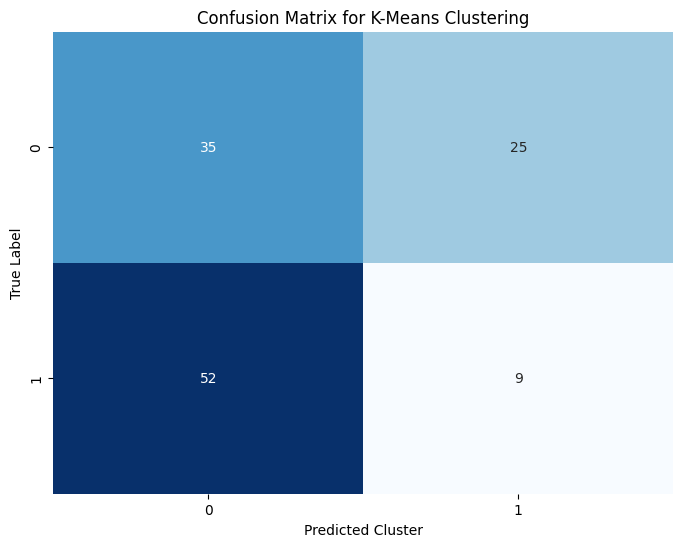

In [133]:
# Create a confusion matrix to compare actual labels with cluster labels
cm = confusion_matrix(y, cluster_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()

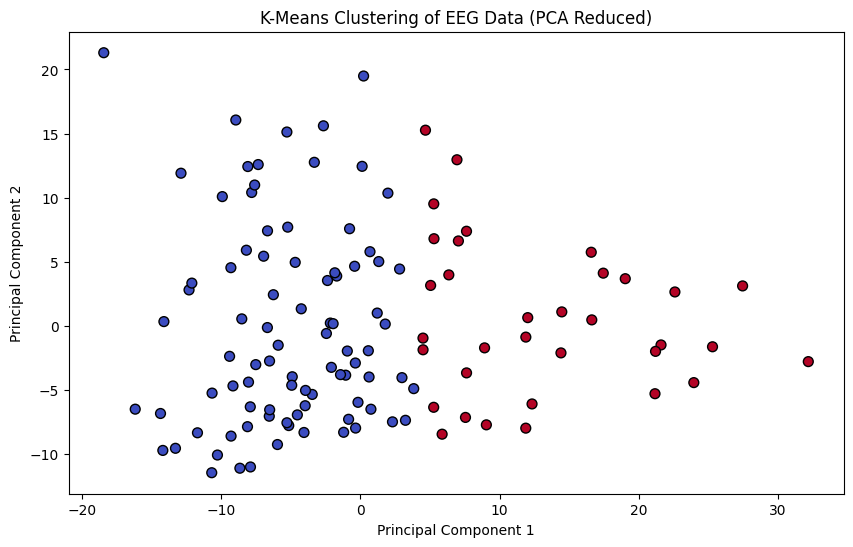

In [134]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of EEG Data (PCA Reduced)')
plt.show()

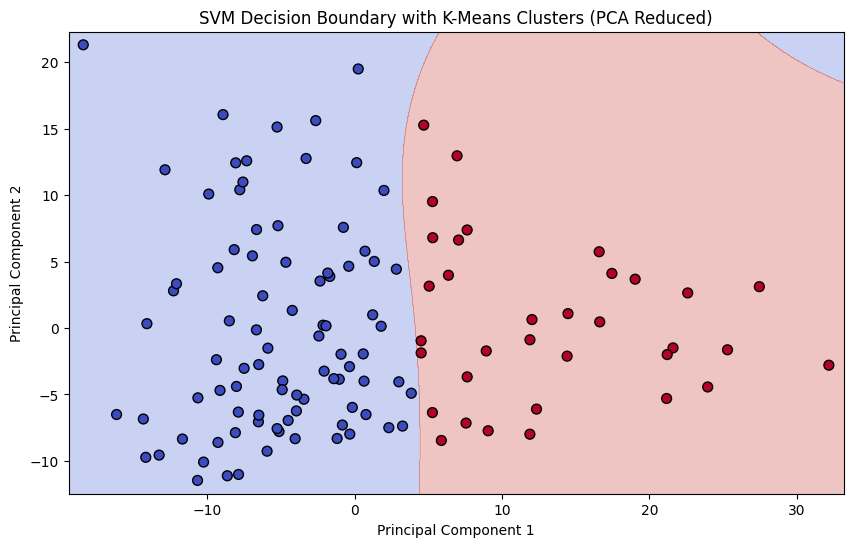

In [138]:
# Assuming X_scaled is your scaled feature matrix from earlier
# and cluster_labels are the labels obtained from K-Means
# Apply PCA to reduce the dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train an SVM model on the PCA-reduced data
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_pca, cluster_labels)

# Predict the SVM decision boundary
h = .02  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the original PCA clusters
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', edgecolor='k', s=50)
plt.title("SVM Decision Boundary with K-Means Clusters (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()